In [1]:
import numpy as np
import scipy.optimize as opt
from scipy.stats import norm, chi2, nbinom, logistic
from matplotlib import pyplot as plt
from NBinomRandomDataGenerator import NBinomRandomDataGenerator
import scipy.linalg as la
import warnings

# Random Data Generation

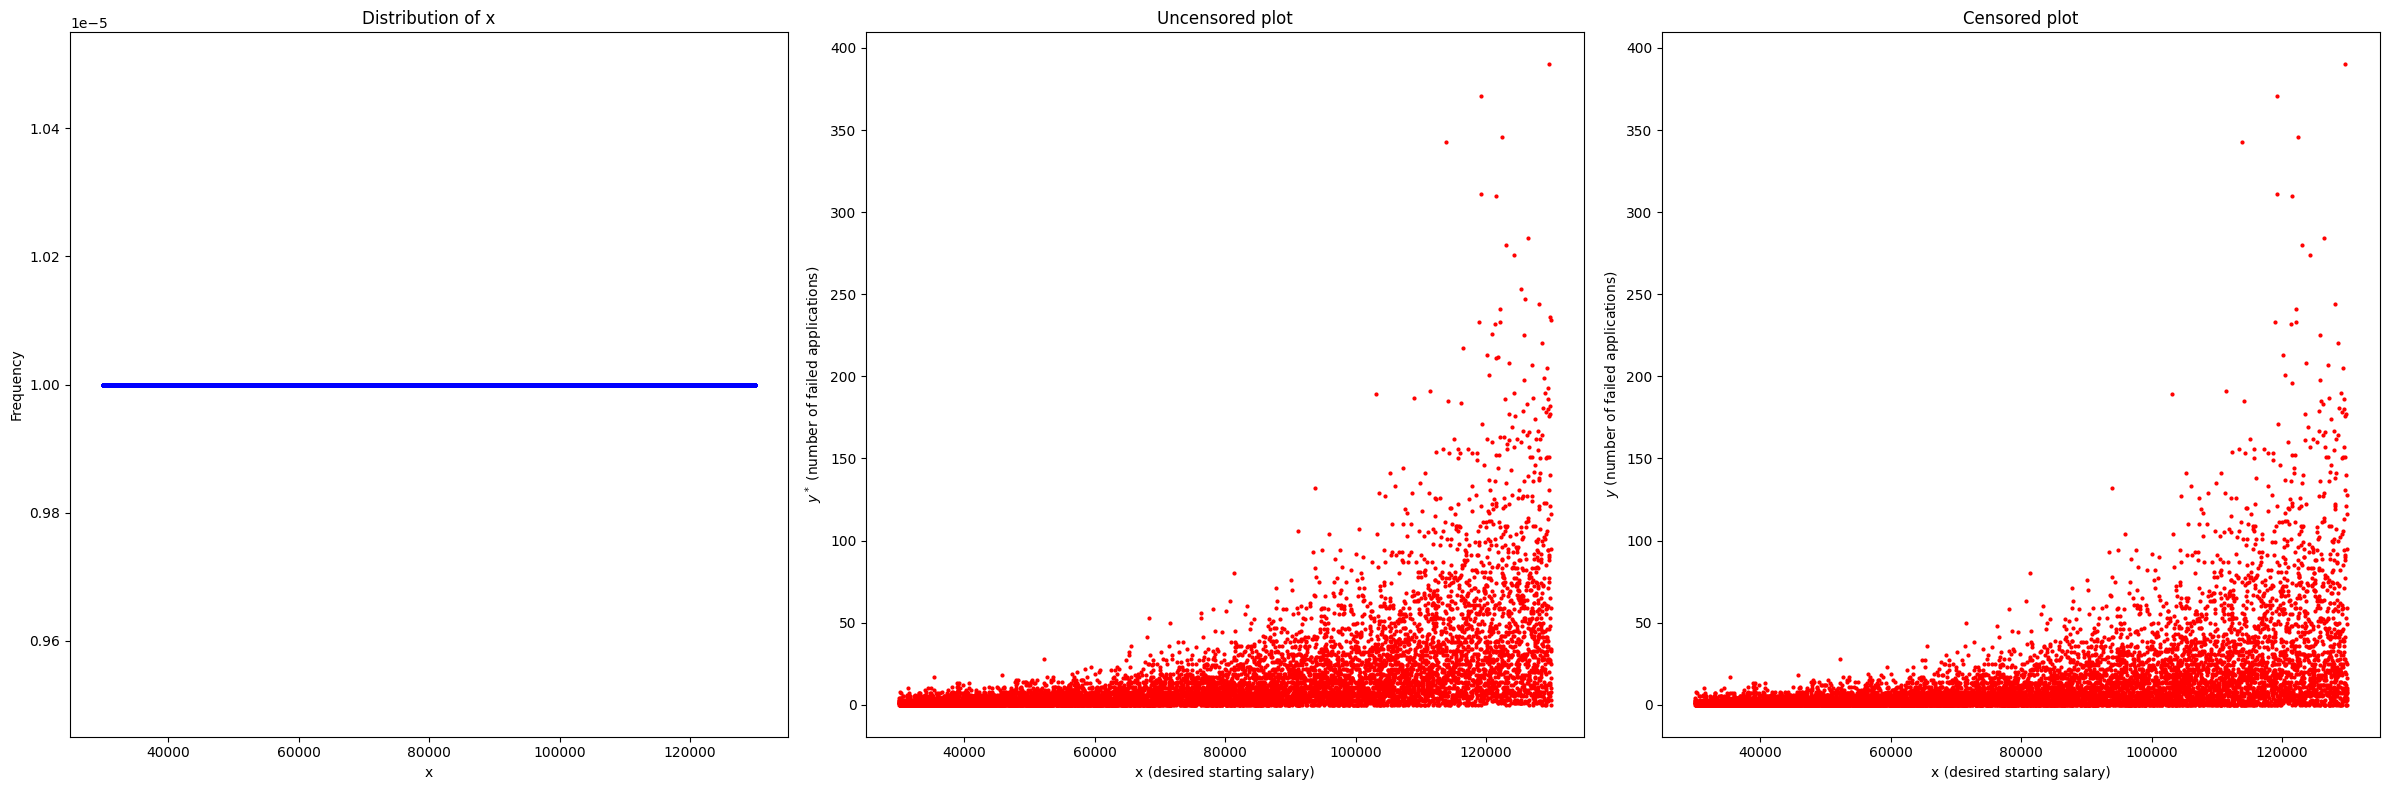

,Desired Starting Salary ($),Rejected Job Applications,Censored
0,51215,1,0
1,49768,0,1
2,74938,8,1
3,54258,2,1
4,96027,31,0
...,...,...,...
9995,33838,0,0
9996,72889,23,0
9997,109039,33,0
9998,85709,2,1


In [2]:
n = 10000
true_beta = np.array([1, -4e-5])

randomData = NBinomRandomDataGenerator(size=n, x_distribution='uniform', beta=true_beta)
data = randomData.createVaryingCensoredData(generate_plots=True)
data

In [3]:
# Organize data
x = data["Desired Starting Salary ($)"]
y = data["Rejected Job Applications"]
T = y.copy()
T[data['Censored'] == 0] = y + 1 #  If there is no censoring, all that matters is T > y
x = x.to_numpy()
y = y.to_numpy()
T = T.to_numpy()

# Maximum Likelihood Estimation

In [4]:
def nbinom_likelihood(b):
    # This is equivalent to the sigmoid function
    p = logistic.cdf(b[0] + b[1]*x)
    
    # Generate mask
    censored_points = y == T
    uncensored_points = y < T

    # Calculate censored and uncensored portions of the likelihood function
    uncensored_portion = np.zeros_like(p)
    censored_portion = np.zeros_like(p)
    uncensored_portion[uncensored_points] = nbinom.logpmf(y[uncensored_points], 1, p[uncensored_points])
    censored_portion[censored_points] = nbinom.logsf(y[censored_points], 1, p[censored_points])

    # Handle nan values by outputting a very negative value
    uncensored_portion[uncensored_points] = np.where(np.isnan(uncensored_portion[uncensored_points]), -1*1e6, uncensored_portion[uncensored_points])
    censored_portion[censored_points] = np.where(np.isnan(censored_portion[censored_points]), -1*1e6, censored_portion[censored_points])
    
    Q = uncensored_portion + censored_portion
    out = -1*np.mean(Q)

    return out

In [5]:
warnings.simplefilter('ignore')
# Find solution using scipy's minimize tools
sol = opt.minimize(nbinom_likelihood, x0=np.array([0, 0]), method='BFGS', options={'disp': True})
print(sol)
# Save the coefficient vector and variance matrix
beta_negbin = sol.x
V = sol.hess_inv # NOTE: Since the likelihood function is defined as negative, we don't need the negative sign to calculate V

         Current function value: 2.489294
         Iterations: 11
         Function evaluations: 204
         Gradient evaluations: 64
  message: Desired error not necessarily achieved due to precision loss.
  success: False
   status: 2
      fun: 2.4892942389671573
        x: [ 9.408e-01 -4.121e-05]
      nit: 11
      jac: [-2.568e-04 -1.107e+01]
 hess_inv: [[ 1.401e+01 -1.521e-04]
            [-1.521e-04  1.858e-09]]
     nfev: 204
     njev: 64


## Marginal Effects: True Distribution

In [6]:
def E_Y(b, x): # The expected value of Y, given beta and x
    return np.exp(-1*(b[0] + b[1]*x))

def d_E_Y(b,x): # The derivative of E_Y wrt x
    return -1*b[1] * np.exp(-1*(b[0] + b[1]*x))

# Calculate the marginal effect for each xi
me_negbin = d_E_Y(beta_negbin, x)

## Marginal Effects: Tobit Model

In [7]:
def tobit_likelihood(b):

    xb = b[1] + b[2]*x
    alpha = (y - xb)  / b[0]

    # Generate mask
    censored_points = y == T
    uncensored_points = y < T

    # Calculate censored and uncensored portions of the likelihood function
    uncensored_portion = np.zeros_like(xb)
    censored_portion = np.zeros_like(xb)
    uncensored_portion[uncensored_points] = np.log((1/b[0])*(norm.pdf(alpha[uncensored_points])))
    censored_portion[censored_points] = norm.logsf((alpha[censored_points]))

    # Handle nan values by outputting a very negative value
    uncensored_portion[uncensored_points] = np.where(np.isnan(uncensored_portion[uncensored_points]), -1*1e6, uncensored_portion[uncensored_points])
    censored_portion[censored_points] = np.where(np.isnan(censored_portion[censored_points]), -1*1e6, censored_portion[censored_points])
    
    Q = uncensored_portion + censored_portion
    out = -1*np.mean(Q)
    if np.isinf(out) or np.isnan(out):
        return 1e6
    return out


In [8]:
warnings.simplefilter('ignore')
bounds = ((0, 500),(-1, 1), (-1,1))

# b0 is std_dev, b1 is beta0, b2 is beta1
sol = opt.differential_evolution(tobit_likelihood, x0=np.array([100, 0.5, 0.5]), bounds=bounds)
print(sol)
beta_tobit = sol.x
# In this case the marginal effect is just b[2]

me_tobit = np.ones_like(x) * beta_tobit[2]

             message: Optimization terminated successfully.
             success: True
                 fun: 3.5899097492895913
                   x: [ 2.606e+01  1.128e-01  2.855e-04]
                 nit: 23
                nfev: 1140
          population: [[ 2.606e+01  1.128e-01  2.824e-04]
                       [ 3.215e+01 -2.131e-01  3.208e-04]
                       ...
                       [ 2.506e+01 -6.099e-01  2.490e-04]
                       [ 2.714e+01  8.925e-01  2.348e-04]]
 population_energies: [ 3.590e+00  3.624e+00 ...  3.596e+00  3.602e+00]
                 jac: [ 8.244e-04  3.118e-03  7.257e-03]


# Comparing Marginal Effects

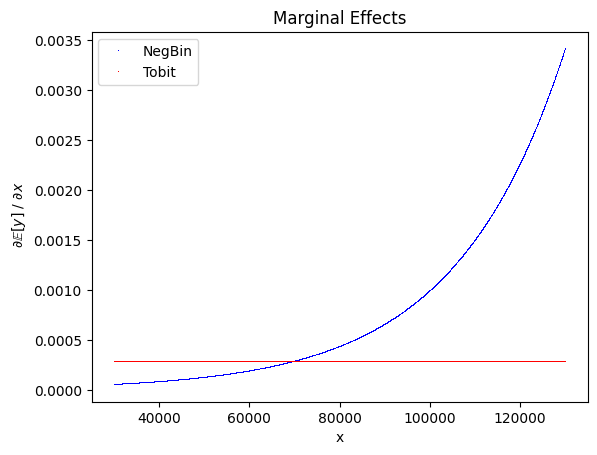

In [9]:
plt.title("Marginal Effects")
plt.plot(x, me_negbin, 'b,', label="NegBin")
plt.plot(x, me_tobit, 'r,', label="Tobit")
plt.xlabel("x")
plt.ylabel(" $\partial \mathbb{E}[y]$ / $\partial x$")
plt.legend()
plt.show()

# Inference

In [10]:
# Wald test. Let's test that \beta_1 is not zero
def Wald(R, b, r, V, n, alpha=0.05):
    W = n*((R@b - r).T @ la.inv(R@V@(R.T))@(R@b-r))
    p_value = 1 - chi2.cdf(x=W, df=np.linalg.matrix_rank(R))

    print(f"Wald statistic: {W}")
    print(f"P value: {p_value}")
    print(f"Alpha: {alpha}")

    if p_value < alpha:
        print("Significance found: H_0 rejected")
    else:
        print("Failed to reject")

    return None

In [11]:
Wald(R=np.array([[0,1]]), b=beta_negbin, r=0, V=V, n=n)

Wald statistic: 9142.353413806082
P value: 0.0
Alpha: 0.05
Significance found: H_0 rejected
